In [1]:
import pickle 
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import random
import scipy.io
from cv2 import copyMakeBorder, flip, BORDER_CONSTANT
import pickle 

from keras.models import Sequential
from keras.layers import Conv2D, Flatten, MaxPooling2D, Dense, BatchNormalization, Dropout


from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Helper Functions

In [3]:
def lossAccPlot(history):
  plt.figure(figsize=(20,5))

  plt.subplot(211)
  plt.title('Loss')
  plt.plot(history.history['loss'], color='b', label='train')
  plt.plot(history.history['val_loss'], color='--r', label='validation')
  plt.legend()

  plt.subplot(212)
  plt.title('Accuracy')
  plt.plot(history.history['accuracy'], color='blue', label='train')
  plt.plot(history.history['val_accuracy'], color='--r', label='validation')
  plt.legend()
  plt.setylim([0,1])

### Importing joints locations and images - correcting size of the images

In [ ]:
coords_file_name = "/content/drive/My Drive/Deep/HW02/lsp_dataset/joints.mat"
joints = scipy.io.loadmat(coords_file_name)
joints = joints['joints'][:2,:]
W = 202
H = 202
image_list = []

for i in range(1,2001):
  if np.mod(i,50)==0:
    print(i)
  if i<10:
    img_name = "im000{0}.jpg".format(i)
  elif i<100:
    img_name = "im00{0}.jpg".format(i)
  elif i<1000:
    img_name = "im0{0}.jpg".format(i)
  else:
    img_name = "im{0}.jpg".format(i)

  img = plt.imread("/content/drive/My Drive/Deep/HW02/lsp_dataset/images/{0}".format(img_name))

  if img.shape[0] < H:
    height = H - img.shape[0]
  else:
    height = 0

  if img.shape[1] < W:
    width = W - img.shape[1]
  else:
    width = 0
  
  if np.mod(width,2) == 0:
    extra_width = 0
  else:
    extra_width = 1

  if np.mod(height,2) == 0:
    extra_height = 0
  else:
    extra_height = 1

  joints[0,:,i-1] = (joints[0,:,i-1] + width/2)/W
  joints[1,:,i-1] = (joints[1,:,i-1] + height/2)/H

  img = copyMakeBorder(img,int(height/2)+extra_height,int(height/2),int(width/2)+extra_width,int(width/2),BORDER_CONSTANT,value=[0,0,0])

  image_list.append(img/255)

In [11]:
with open('/content/drive/My Drive/Deep/HW02/lsp_dataset/images_aug.pkl', 'wb') as f:
    pickle.dump(image_list, f)

with open('/content/drive/My Drive/Deep/HW02/lsp_dataset/joints_aug.pkl', 'wb') as f:
    pickle.dump(joints, f)

In [2]:
with open('/content/drive/My Drive/Deep/HW02/lsp_dataset/images_aug.pkl', 'rb') as f:
    image_list = pickle.load(f)

with open('/content/drive/My Drive/Deep/HW02/lsp_dataset/joints_aug.pkl', 'rb') as f:
    joints = pickle.load(f)

### Data Agmuntation

In [6]:
augment_boolian = 1
W = 202
H = 202
if augment_boolian == 1:
  for i in range(0,2000):
    img = image_list[i]
    img = flip(img,1)
    new_coords = joints[:,:,i]
    new_coords[0,:] = (W - W*new_coords[0,:])/W
    joints = np.dstack((joints, new_coords))
    image_list.append(img)

(2, 14, 4000)


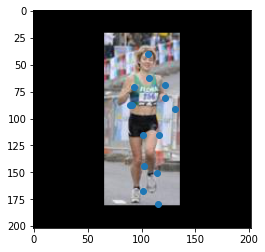

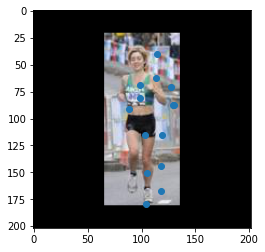

In [10]:

img = image_list[0]
plt.imshow(img)
plt.scatter(joints[0,:,0]*220, joints[1,:,0]*220)
plt.figure()
plt.imshow(flip(img,1))
plt.scatter(220 - joints[0,:,0]*220, joints[1,:,0]*220)

### Separating train, test, and validation

In [4]:
num_train = 1600*2+160
num_validation = 160*2
W = 202
H = 202

X_train = np.array(image_list[0:num_train])
Y_train = np.array(joints[:,:,0:num_train])

X_train = np.reshape(X_train,(num_train,W,H,3))
Y_train = np.transpose(np.reshape(Y_train,(28,num_train)))


X_validation = np.array(image_list[num_train:num_train+num_validation])
Y_validation = np.array(joints[:,:,num_train:num_train+num_validation])

X_validation = np.reshape(X_validation,(num_validation,W,H,3))
Y_validation = np.transpose(np.reshape(Y_validation,(28,num_validation)))


X_test = image_list[num_train+num_validation:num_train+num_validation+num_validation]
Y_test = joints[:,:,num_train+num_validation:num_train+num_validation+num_validation]

X_test = np.reshape(X_validation,(num_validation,W,H,3))
Y_test = np.transpose(np.reshape(Y_test,(28,num_validation)))

del image_list
del joints

In [7]:
print(X_validation.shape)
print(Y_validation.shape)
print(X_train.shape)
print(Y_train.shape)

(320, 202, 202, 3)
(320, 28)
(3360, 202, 202, 3)
(3360, 28)


### Implementing The DNN

In [ ]:
batch_size = 32
epochs_number = 240
learning_rate = 5e-5
momentum = 0.9


model = tf.keras.models.Sequential()

model.add(Conv2D(48, (11, 11), activation='relu', strides=4, kernel_initializer='he_uniform', padding='same',  input_shape=(W, H, 3)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(128, (5, 5), activation='relu', strides=2, kernel_initializer='he_uniform', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(192, (3, 3), activation='relu', strides=1, kernel_initializer='he_uniform', padding='same'))

model.add(Conv2D(192, (3, 3), activation='relu', strides=1, kernel_initializer='he_uniform', padding='same'))

model.add(Conv2D(192, (3, 3), activation='relu', strides=1, kernel_initializer='he_uniform', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2), padding='same'))

model.add(Flatten())

model.add(Dense(4096, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(4096, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(28, activation='linear'))

def soft_acc(y_true, y_pred):
    return tf.keras.backend.mean(tf.keras.backend.equal(tf.keras.backend.round(y_true), tf.keras.backend.round(y_pred)))

def l2_loss(y_true, y_pred):
  x_diff =  y_true[0:14] - y_pred[0:14]
  y_diff =  y_true[14:28] - y_pred[14:28]
  diff = tf.math.pow(x_diff,2) + tf.math.pow(y_diff,2)
  return tf.keras.backend.sum(diff)


optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
model.compile(loss=l2_loss , optimizer=optimizer, metrics=[soft_acc])
history = model.fit(X_train, Y_train, epochs=epochs_number, batch_size=batch_size, validation_data=(X_validation, Y_validation))

lossAccPlot(history)

Epoch 1/240
105/105 [==============================] - 18s 54ms/step - loss: 315.8901 - soft_acc: 0.4994 - val_loss: 42.7084 - val_soft_acc: 0.5748
Epoch 2/240
105/105 [==============================] - 5s 47ms/step - loss: 48.9333 - soft_acc: 0.6029 - val_loss: 17.3117 - val_soft_acc: 0.6509
Epoch 3/240
105/105 [==============================] - 5s 47ms/step - loss: 28.9779 - soft_acc: 0.6247 - val_loss: 15.0019 - val_soft_acc: 0.6735
Epoch 4/240
105/105 [==============================] - 5s 47ms/step - loss: 21.6650 - soft_acc: 0.6395 - val_loss: 14.6672 - val_soft_acc: 0.6626
Epoch 5/240
105/105 [==============================] - 5s 49ms/step - loss: 18.0864 - soft_acc: 0.6525 - val_loss: 14.4886 - val_soft_acc: 0.6664
Epoch 6/240
105/105 [==============================] - 5s 48ms/step - loss: 15.9617 - soft_acc: 0.6612 - val_loss: 12.3552 - val_soft_acc: 0.6737
Epoch 7/240
105/105 [==============================] - 5s 48ms/step - loss: 14.5933 - soft_acc: 0.6649 - val_loss: 13.3017

In [ ]:
epochs_number = 960+240
model.fit(X_train, Y_train, epochs=epochs_number, batch_size=batch_size, validation_data=(X_validation, Y_validation), initial_epoch=960)

Epoch 961/1200
12/12 [==============================] - 2s 179ms/step - loss: 6.2035 - soft_acc: 0.6888 - val_loss: 7.2922 - val_soft_acc: 0.6958
Epoch 962/1200
12/12 [==============================] - 2s 147ms/step - loss: 6.0324 - soft_acc: 0.7030 - val_loss: 7.0268 - val_soft_acc: 0.7056
Epoch 963/1200
12/12 [==============================] - 2s 153ms/step - loss: 5.5025 - soft_acc: 0.7019 - val_loss: 7.0289 - val_soft_acc: 0.6953
Epoch 964/1200
12/12 [==============================] - 2s 150ms/step - loss: 5.8006 - soft_acc: 0.7044 - val_loss: 6.8574 - val_soft_acc: 0.6803
Epoch 965/1200
12/12 [==============================] - 2s 150ms/step - loss: 5.3814 - soft_acc: 0.7051 - val_loss: 7.1369 - val_soft_acc: 0.7060
Epoch 966/1200
12/12 [==============================] - 2s 151ms/step - loss: 5.5751 - soft_acc: 0.7083 - val_loss: 6.8535 - val_soft_acc: 0.7293
Epoch 967/1200
12/12 [==============================] - 2s 149ms/step - loss: 5.1062 - soft_acc: 0.7190 - val_loss: 6.7936 -

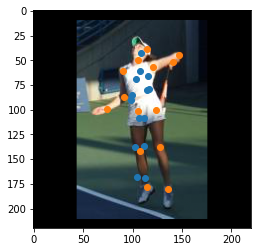

In [ ]:
test = model.predict(X_validation)
img_number = 229
plt.imshow(X_validation[img_number])
plt.scatter(test[img_number,0:14]*220, test[img_number,14:28]*220)
plt.scatter(Y_validation[img_number,0:14]*220, Y_validation[img_number,14:28]*220)